# Serious Work Injuries: United States 2015 to 2017 
_By Nick Brooks, February 2018_

Follow me through this analysis. Not for the faint of heart. 

# Tables of Content:

**1. What does this Dataset consist of?** <br>
**2. Dataset Fixing** <br>
**3. Univariate Anlysis** <br>
**4. Multivariate Analysis** <br>
**5. Horrible Incidents** <br>

## Dataset Fixing <br>
- Drop Unwanted
- Change DataTypes
- Impute
- Date Time Conversion
- Remove ALL-CAPS from City and State

In [1]:
import os
import pandas as pd
path= r"/Users/nicapotato/Google Drive/Learning/Jupyter/Data/injured-workers" # MAC
#path= r"C:\Users\Nicol\Google Drive\Learning\Jupyter\Data\injured-workers" # Windows
os.chdir(path)

#df = pd.read_csv(open(os.path.join(path, "severeinjury.csv"), "r",encoding="latin-1"))
df = pd.read_csv("severeinjury.csv", encoding="latin-1")

In [2]:
# General Imports
import numpy as np
import pandas as pd

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Load
#df = pd.read_csv("../input/severeinjury.csv", encoding="latin-1")

## Processing
# Drop Unwanted
df.drop(["ID","UPA","Address1","Address2","Primary NAICS","Inspection",
         "Nature","Part of Body","Event","Source","Secondary Source"],axis=1,inplace=True)

# Change Dtypes
df.Hospitalized = df.Hospitalized.astype(int)
df.Amputation= df.Amputation.fillna(0).astype(int)
df['EventDate'] = pd.to_datetime(df["EventDate"])

# Capitalize Category Values
for x in ["City","State"]:
    df[x] = df[x].str.capitalize()

# Clean Employer Variable
df["Employer"] = df["Employer"].str.capitalize().str.replace('[^\w\s]','')
df.loc[df.Employer.str.contains(r"(?i)Postal Service|(?i)States Postal|(?i)USPS"),"Employer"] = "US postal service"
df.loc[df.Employer.str.contains(r"\b(?i)ups\b"),"Employer"] = 'United parcel service'
# Remove company type from name.
df["Employer"] = df.Employer.str.replace(r"\binc\b|\bllc\b|\blde\b|\bco\b|\bcorp\b|\bllp\b", '').str.strip()

"""
Regular Expressions:
I noticed that companie names were recorded in multiple different ways. This is an attempt to unify these inconsistencies.

Regular Expression Explanation:
- [^\w\s] : [^] Negatve Set \w Words \s White Spaces
- (?i)ups : Removes case sensitivity from ups -> UPS, UPs, ups etc. would be returned
- r"\bups\b" : In this case "ups" will only be returned if it borders (b) a non-letter. e.i its a exact word.
- | : Represents "or" argument

Creating the Gender Variable:
"""

# New Variables
df["Male"] = False
df["Female"] = False

# True when gender pronoun appears
df.loc[df['Final Narrative'].str.contains(
    r'(?i)\bhis\b|(?i)\bhe\b|(?i)\bmale\b|(?i)\bhim\b'),["Male"]] = True
df.loc[df['Final Narrative'].str.contains(
    r'(?i)\bhers\b|(?i)\bshe\b|(?i)\bfemale\b|(?i)\bher\b'),["Female"]] = True

# Gender Var
df["Gender"] = "NULL"
df.loc[(df.Male == True),"Gender"] = "Male"
df.loc[(df.Female == True),"Gender"] = "Female"
df.loc[(df.Female == True)&(df.Male == True),"Gender"] = "Both Mentioned"

"""
Hospitalized/Amputated - Binary Variable
"""

# Fast funcdtion for top occruence categories
def topcat_index(series, n=5):
    """
    Wow! 2 charcters SAVED on function length
    """
    return series.value_counts().index[:n]
def topcats(series, n=5):
    return series.isin(topcat_index(series, n=n))

## New Amputation Variable
df["Amputated"]= False
df.loc[df["Amputation"] > 0,"Amputated"] = True

# New Hospital
df["Hospital"]= False
df.loc[df["Hospitalized"] > 0,"Hospital"] = True

print("Pre-Processing Complete")

Pre-Processing Complete


In [3]:
print("Examine Gender Variable:")
for x in ["Male","Female","Gender"]:
    print("\n{}:\n".format(x))
    print(df[x].value_counts())
    print(df[x].value_counts(normalize=True))

print("\n{} % of the time, both gender pronouns are precent".format(
    round((df[(df.Male == True) & (df.Female == True)].shape[0]/df.shape[0])*100,2)))

Examine Gender Variable:

Male:

False    11542
True     10036
Name: Male, dtype: int64
False    0.534897
True     0.465103
Name: Male, dtype: float64

Female:

False    19829
True      1749
Name: Female, dtype: int64
False    0.918945
True     0.081055
Name: Female, dtype: float64

Gender:

Male              9994
NULL              9835
Female            1707
Both Mentioned      42
Name: Gender, dtype: int64
Male              0.463157
NULL              0.455788
Female            0.079108
Both Mentioned    0.001946
Name: Gender, dtype: float64

0.19 % of the time, both gender pronouns are precent


Since the gender was omitted in the dataset, this variable is forced since half the time, no pronoun is used. 
Furthermore, since I am merely looking at pronoun mentions, the pronoun may belong to the rescuer/report writer, not the injured laborer.

To be taken with a grain of salt.

***
**Dataset I'll be working with:** <br>

In [4]:
def custom_describe(df):
    """
    I am a non-comformist :)
    """
    unique_count = []
    for x in df.columns:
        mode = df[x].mode().iloc[0]
        unique_count.append([x,
                             len(df[x].unique()),
                             df[x].isnull().sum(),
                             mode,
                             df[x][df[x]==mode].count(),
                             df[x].dtypes])
    print("Dataframe Dimension: {} Rows, {} Columns".format(*df.shape))
    return pd.DataFrame(unique_count, columns=["Column","Unique","Missing","Mode","Mode Occurence","dtype"]).set_index("Column").T

custom_describe(df)

Dataframe Dimension: 21578 Rows, 20 Columns


Column,EventDate,Employer,City,State,Zip,Latitude,Longitude,Hospitalized,Amputation,Final Narrative,NatureTitle,Part of Body Title,EventTitle,SourceTitle,Secondary Source Title,Male,Female,Gender,Amputated,Hospital
Unique,790,15962,4643,56,7976,2150,3605,4,6,21562,149,118,307,903,629,2,2,4,2,2
Missing,0,0,9,0,11,91,91,0,0,0,0,0,0,0,15766,0,0,0,0,0
Mode,2015-09-02 00:00:00,US postal service,Houston,Texas,32830,40.76,-81.53,1,0,An employee suffered a finger amputation.,Fractures,"Finger(s), fingernail(s), n.e.c.",Caught in running equipment or machinery durin...,"Floor, n.e.c.","Ice, sleet, snow",False,False,Male,False,True
Mode Occurence,56,415,403,3481,69,69,65,17128,15791,3,6018,2790,1893,1275,555,11542,19829,9994,15791,17280
dtype,datetime64[ns],object,object,object,float64,float64,float64,int64,int64,object,object,object,object,object,object,bool,bool,object,bool,bool


- Looks heathlier. Employer classes dropped by almost two thousand, so I think the written inconsistencies are partly handled.
- *Part of Body Title, Source Title, Secondary Source Title* all forshadow the terrible nature of these accidents. What am I getting myself into.

***
## Univariate Analysis
Important to start with a general understanding of the variables. Distribution convey a lot of information about the reality of accidents, as well as inform the statistician on which tools he can bring to this data.

**Time:** <br>
I like to look at the pattern on different time scales.

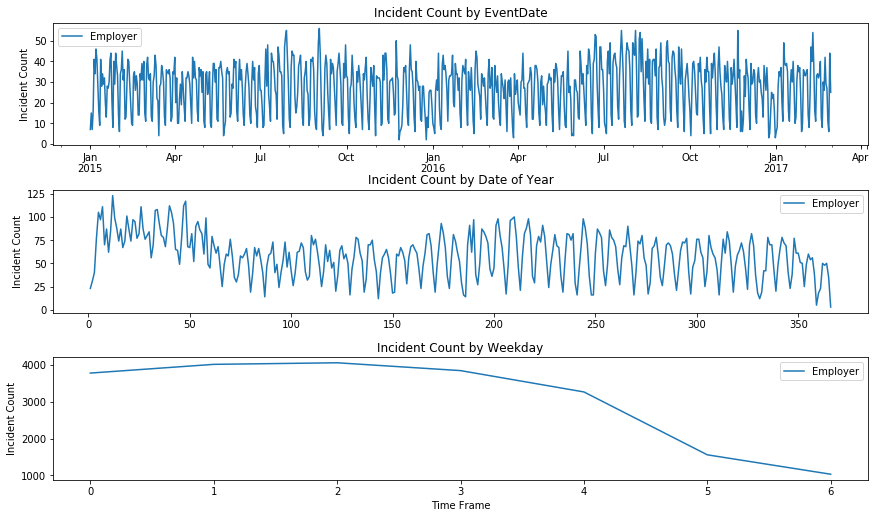

In [5]:
def time_slicer(df, timeframes):
    """
    Function to count observation occurrence through different lenses of time.
    """
    f, ax = plt.subplots(len(timeframes), figsize = [12,7])
    for i,x in enumerate(timeframes):
        df.loc[:,[x,"Employer"]].groupby([x]).count().plot(ax=ax[i])
        ax[i].set_ylabel("Incident Count")
        ax[i].set_title("Incident Count by {}".format(x))
        ax[i].set_xlabel("")
    ax[len(timeframes)-1].set_xlabel("Time Frame")
    plt.tight_layout(pad=0)
    
# Time Frames of Interest
df["Date of Year"] = df['EventDate'].dt.dayofyear # Day of Year
df["Weekday"] = df['EventDate'].dt.weekday 
# Plot
time_slicer(df=df,timeframes=["EventDate","Date of Year","Weekday"])

**Interpretation:** <br>
1. The top plot suggests a stationary pattern over the two years of data.
2. The second plot suggests an uptick in incidents after New Years, and during the Summer. There is a seasonal/holiday effect at play here.
3. The last plot suggests that popular culture unfairly condemns Mondays, while Tueday and Wednesday may in fact be the real perpetrators.
4. In terms of the Friday and Weekend decrease, I would require the numbers of laborers by weekday to make any statement on the risk of working on weekends. I am also surprised to so many accidents on weekends.

***
### Categorical Variables:
Yep.. Bar charts.

**Hospitalization and Amputation :(**

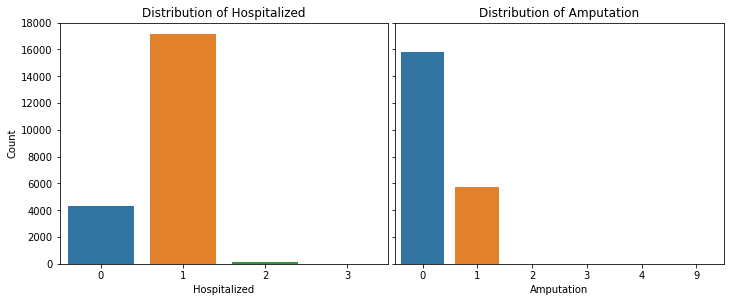

In [6]:
f, ax = plt.subplots(1,2, figsize=[10,4],sharey=True)
sns.countplot(df["Hospitalized"],ax=ax[0])
ax[0].set_title("Distribution of Hospitalized")
ax[0].set_ylabel("Count")
sns.countplot(df["Amputation"],ax=ax[1])
ax[1].set_title("Distribution of Amputation")
ax[1].set_ylabel("")
plt.tight_layout(pad=0)

**Interpretation:** <br>
Ok, so while hospitalization is common (and sometimes for more than one time per accident), amputation is not.

***
**Employer, City, and State:** <br>

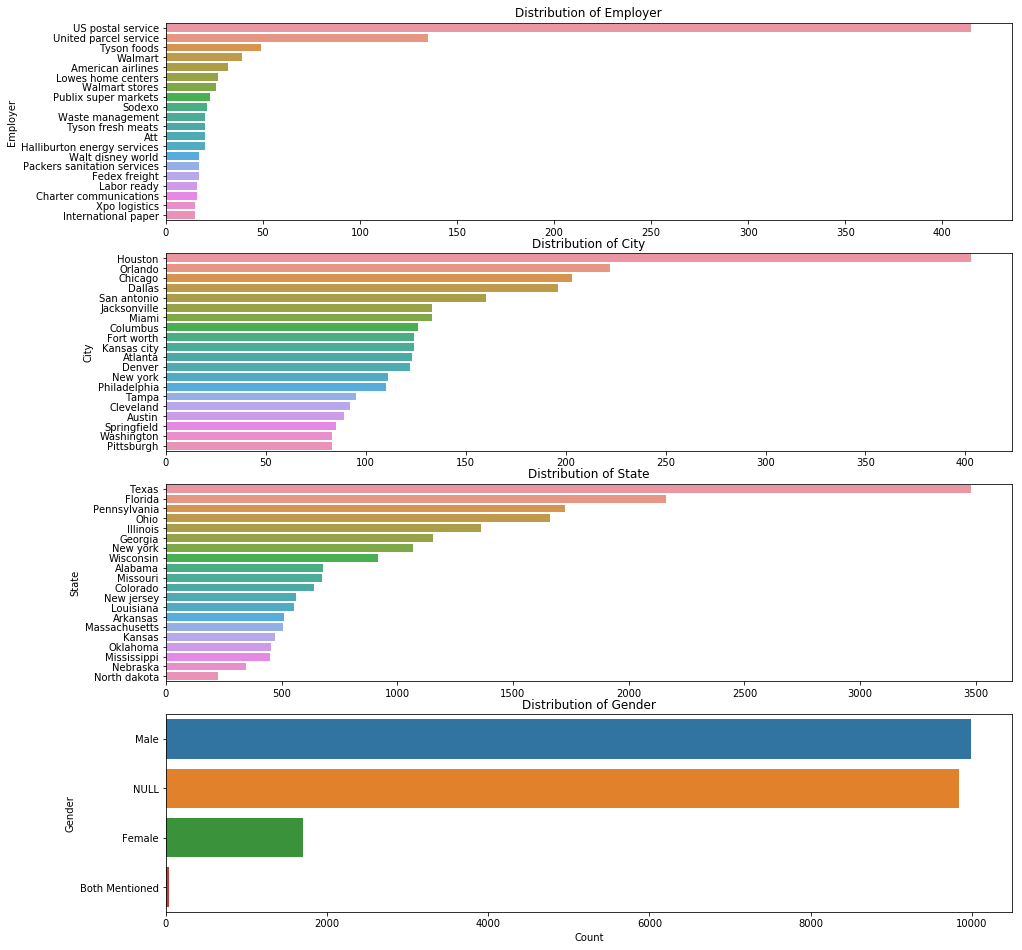

In [7]:
def cat_countplot(df, var, size = [8,10], n=15):
    """
    Function to plot multiple seaborn count plots horizontally, and ordered by most frequent class.
    """
    f, ax = plt.subplots(len(var),figsize=size)
    for i,x in enumerate(var):
        temptop = df[x].value_counts().index[:n]
        sns.countplot(y=df[x][df[x].isin(temptop)], order=temptop, ax=ax[i])
        ax[i].set_title("Distribution of {}".format(x))
        ax[i].set_xlabel("")
    ax[len(var)-1].set_xlabel("Count")
    plt.tight_layout(pad=0)

def continous_plots(df, var):
    """
    Built this and found it doesn't apply to my problem at hand.
    """
    f, ax = plt.subplots(1,len(var),figsize=(12,4), sharey=False)
    for i,x in enumerate(var):
        sns.distplot(df[x], ax=ax[i])
        ax[i].set_title("{} Distribution".format(x))
        ax[i].set_ylabel("")
        ax[i].set_xlabel("Distribution")
    ax[0].set_ylabel("Density")
    plt.tight_layout()
    
# Plot
cat_countplot(df=df, var=["Employer","City","State", "Gender"],n=20, size=[14,13])

**Interpretation:** <br>
Texas and Florida are leaders of pack. Once again, would be best to scale for total laborers before making statements about the risk of these states.

I am quite surprised to find so many incidents occuring at the postal services USPS and UPS. 

Something that must be investigated are the incidents at Walt Disney World.
***
**NatureTitle and Source Title:** <br>

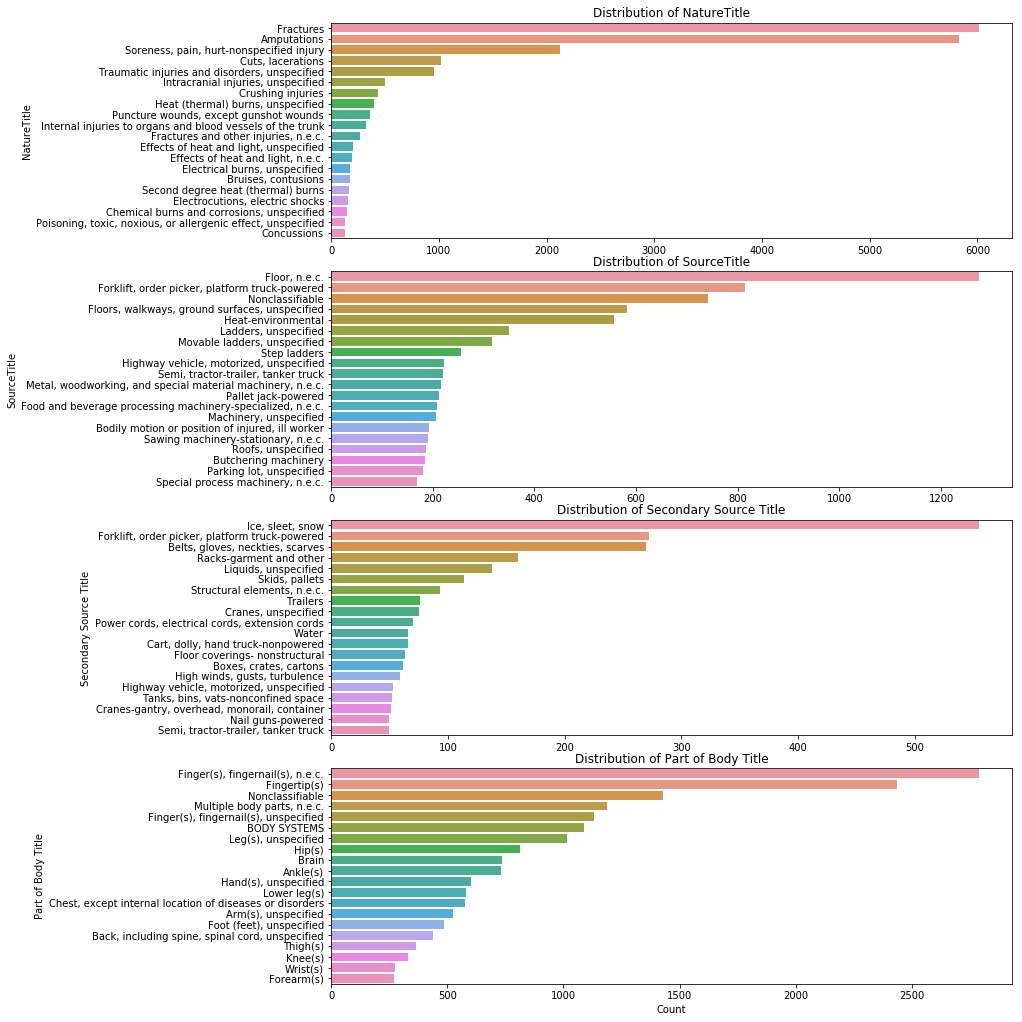

In [8]:
cat_countplot(df=df, var=["NatureTitle","SourceTitle","Secondary Source Title","Part of Body Title"],n=20,size=[14,14])

**Interpretation:** <br>
Yikes.

1. The accident source seems to be mostly passive, such as the floor, ladders, roofs.
2. The second biggest perpetrator are work machinery, such as lifts, vehicles.

***
**Event Title:** <br>

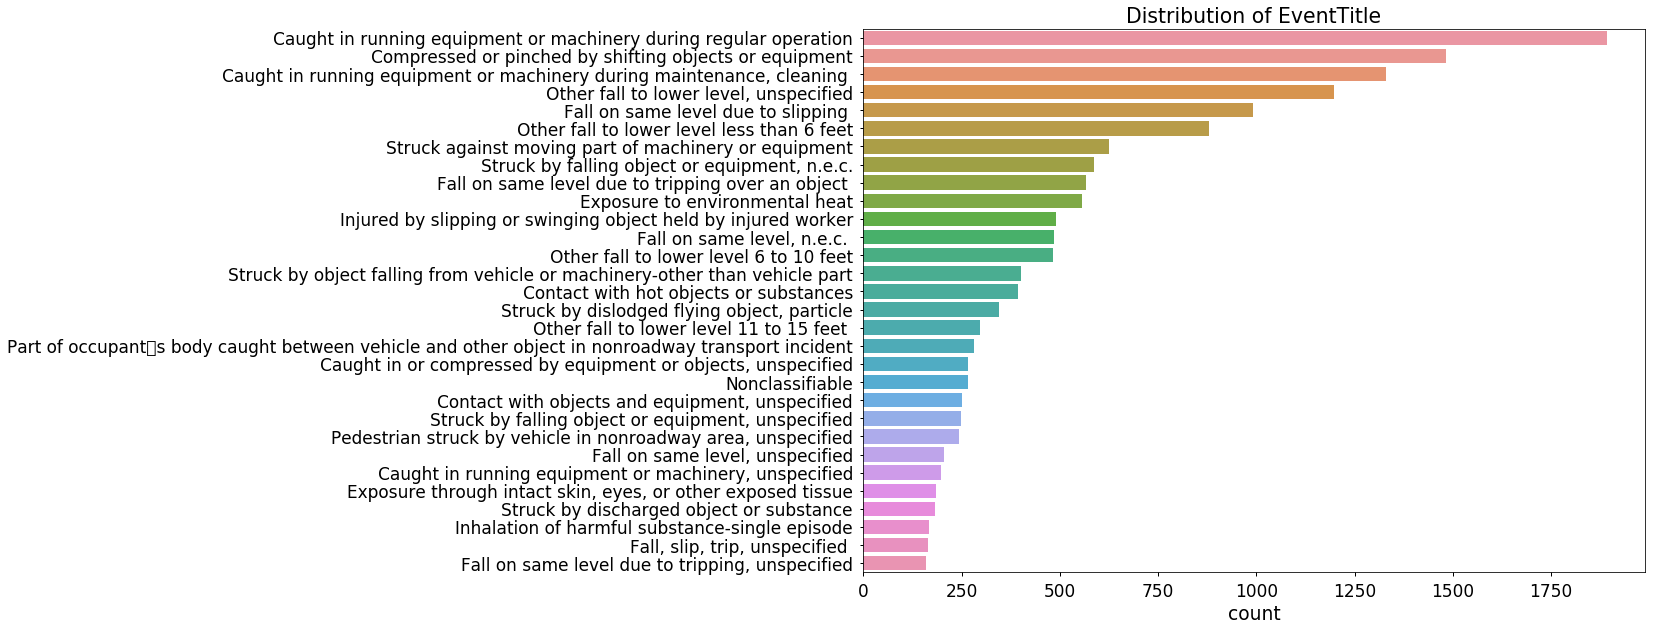

In [9]:
with sns.plotting_context("notebook", font_scale=1.7):
    f, ax = plt.subplots(1,figsize=[14,10])
    x= "EventTitle"
    n=30
    temptop = df[x].value_counts().index[:n]

    sns.countplot(y=df[x][df[x].isin(temptop)], order=temptop, ax=ax)
    ax.set_title("Distribution of {}".format(x))
    ax.set_ylabel("")
plt.show()

**Interpretation:** <br>
Someone runnining machinery seems more dominant here than in the *SourceTitle* distribution.

In [10]:
for x in ["EventTitle", "SourceTitle"]:
    print("{} Class Count: {}".format(x,len(set(df[x]))))
    print("{} STD: {}\n".format(x,df[x].value_counts().std()))

EventTitle Class Count: 307
EventTitle STD: 204.9395158281027

SourceTitle Class Count: 903
SourceTitle STD: 71.09214699646407



Perhaps it is because there are more SourceTitle Classes, with less drastic differences between them than EventTitle.

***
## Multivariate
What intervariable effects are at play?

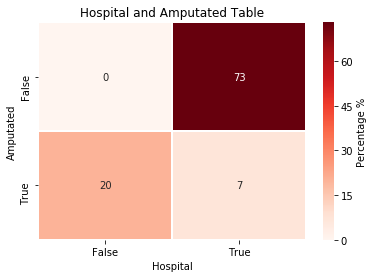

In [11]:
sns.heatmap(pd.crosstab(df['Amputated'], df["Hospital"], normalize=True).mul(100).round(0),
            annot=True, linewidths=.5,fmt='g', cmap="Reds",
                cbar_kws={'label': 'Percentage %'})
plt.title("Hospital and Amputated Table")
plt.show()

**Interpretation:** <br>
This doesn't make sense... Amputated but **NOT** Hospitalized?? These companies cutting cost? J'ACCUSE!!

***

**Some Factor Plot:** <br>

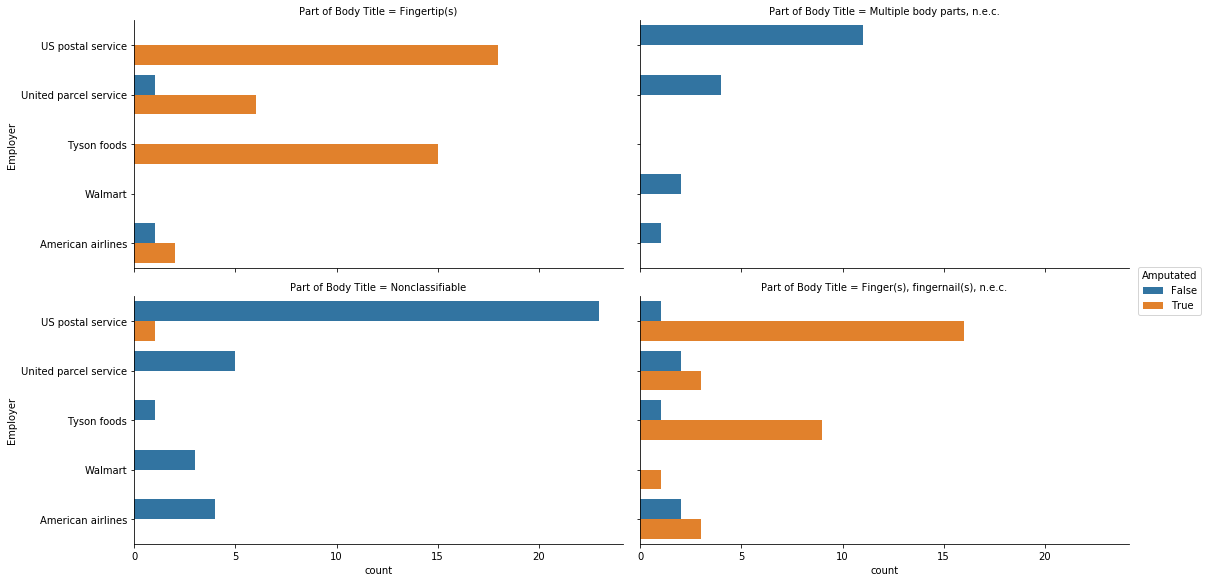

In [12]:
col = "Part of Body Title"
temp = df.loc[(topcats(df["Employer"]))
              &(topcats(df[col],n=4))
              ,:]
sns.factorplot(y="Employer", hue="Amputated", col=col, col_wrap=2,
            data=temp, kind="count",
               order=df["Employer"].value_counts().index[:5],aspect=2)
plt.show()

Makes me wonder which accidents lead to the most amputations.
***
**Looking at Amputation Rates:** <br>

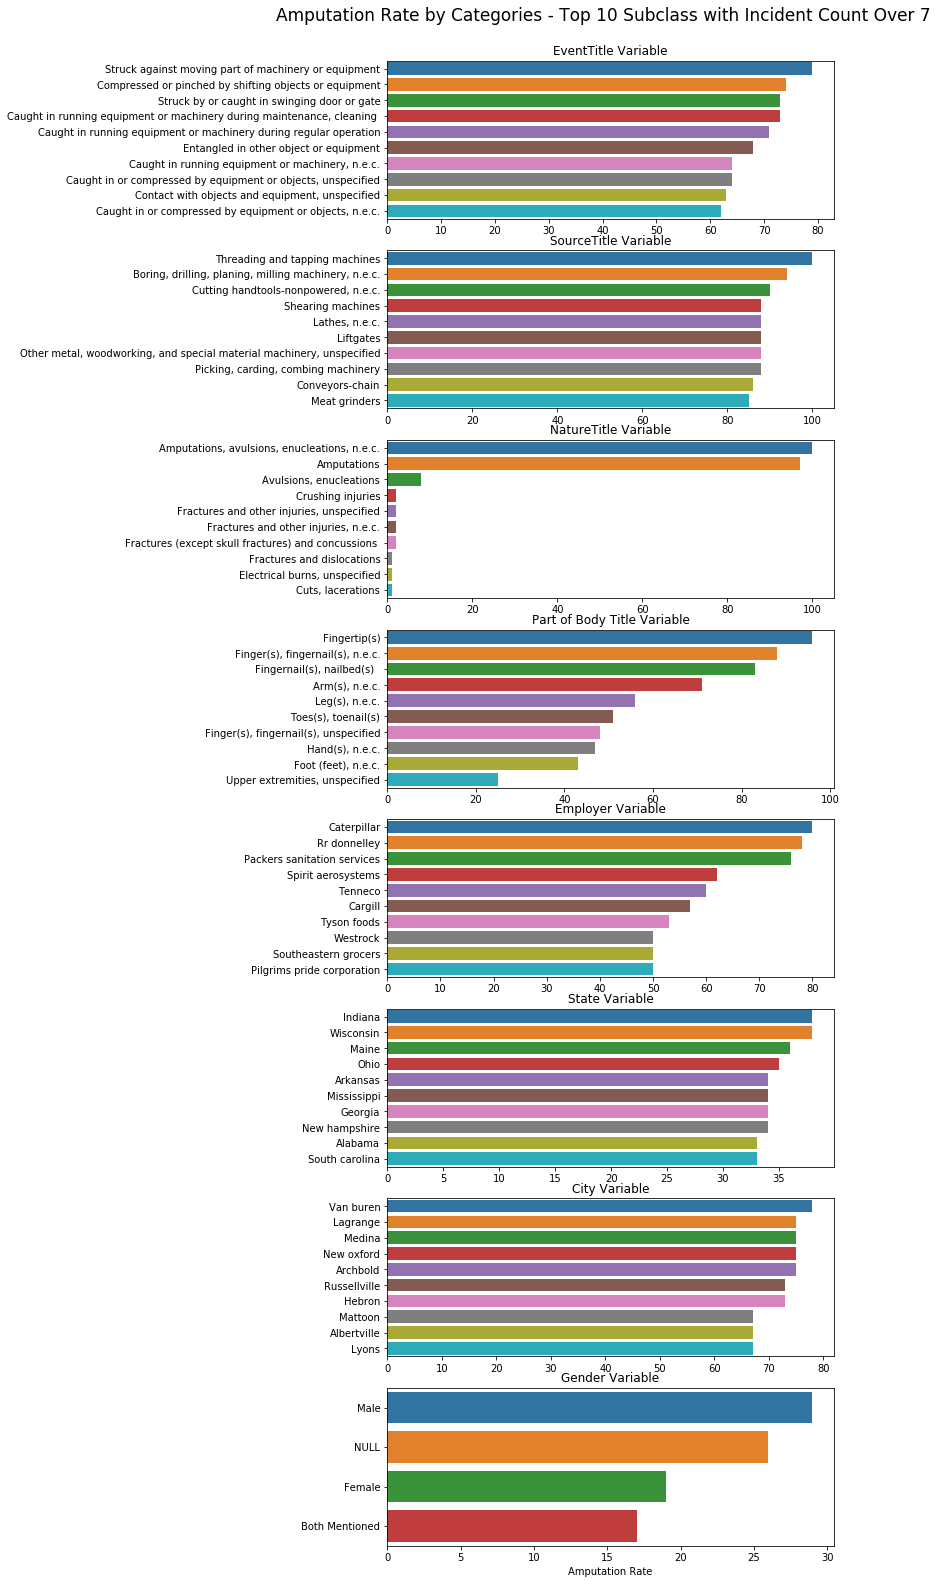

In [14]:
# Helper
def target_rate_by(df, target, by):
    """
    So I can look at amputated (target) rate through different lenses (by)
    """
    amp_rates = (pd.crosstab(df[by], df[target], normalize = 'index')
                 .mul(100).round(0).reset_index())
    amp_rates.columns = [by, "False Rate","Rate"]
    amp_rates["Count"] = "NaN"
    
    for x in set(amp_rates[by]):
        amp_rates.loc[amp_rates[by]==x, "Count"] = df.loc[df[by]==x, by].count()

    return (amp_rates[[by,"Rate", "Count"]]
     .sort_values(by="Rate",ascending=False))

# Plot
variables = ["EventTitle","SourceTitle","NatureTitle","Part of Body Title",
             "Employer","State","City","Gender"]
top = 10
limit = 7

# Plot
f, ax = plt.subplots(len(variables),figsize=[8,25])
for i,x in enumerate(variables):
    temp = target_rate_by(df=df, target="Amputated", by=x) # Custom Function
    sns.barplot(x="Rate",y=x, ax=ax[i],
                data= temp.loc[(temp.Count > limit)][:top])
    ax[i].set_title("{} Variable".format(x))
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
ax[len(variables)-1].set_xlabel("Amputation Rate")
#plt.tight_layout(pad=0)
plt.subplots_adjust(top=0.95)
plt.suptitle('Amputation Rate by Categories - Top {} Subclass with Incident Count Over {}'
             .format(top,limit),fontsize=17)
plt.show()

**No Interpretation:** <br>
Lots of upack here.. I'll let you come to your own conclusions.
***
### **Times Series:** <Br>

In [15]:
def cat_time_slicer(df, slicevar, n, timeframes):
    """
    Function to count observation occurrence through different lenses of time.
    """
    f, ax = plt.subplots(len(timeframes), figsize = [12,7])
    top_classes = topcat_index(df[slicevar],n=n)
    for i,x in enumerate(timeframes):
        for y in top_classes:
            total = df.loc[df[slicevar]==y,slicevar].count()
            ((df.loc[(df[slicevar]==y),[x,"Employer"]]
             .groupby([x])
             .count()/total)
            .plot(ax=ax[i], label=y))
        ax[i].set_ylabel("Percent of\nCompany Incidents")
        ax[i].set_title("Percent of Incident by Company by {}".format(x))
        ax[i].set_xlabel("")
        ax[i].legend(top_classes, fontsize='large', loc='center left',bbox_to_anchor=(1, 0.5))
    ax[len(timeframes)-1].set_xlabel("Time Frame")
    plt.tight_layout(pad=0)
    plt.subplots_adjust(top=0.90)
    plt.suptitle('Normalized Time-Series for top {} {}s over different over {}'.format(n,slicevar,timeframes),fontsize=17)

**By Employer:** <br>

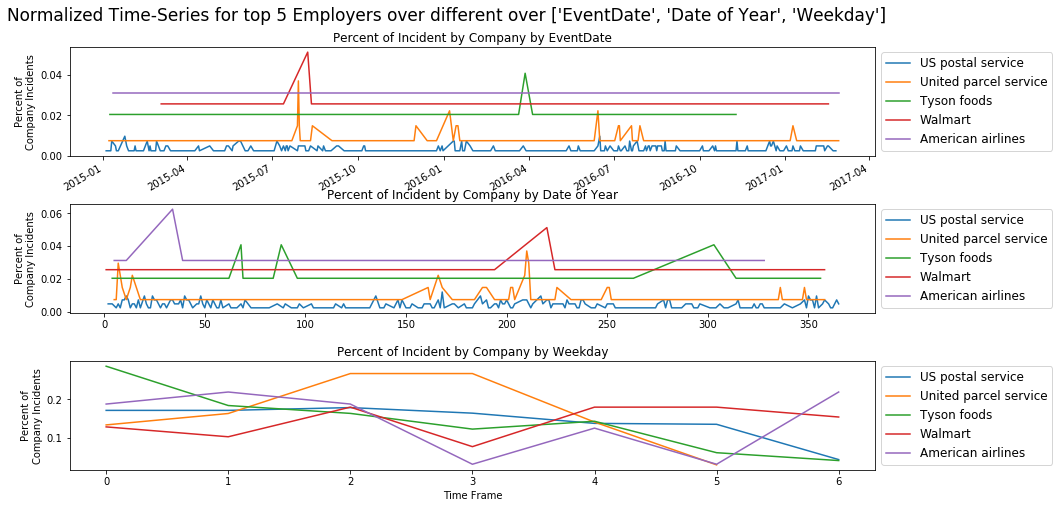

In [16]:
cat_time_slicer(df=df, slicevar = "Employer",
                n=5, timeframes=["EventDate","Date of Year","Weekday"])

**Interpretation:** <br>
Mondays are the most dangerous at the US Postal Service, and Wednesday are the most dangerous for United Parel Service.

Also, US Postal's accidents are frequent, while other companies have incidents once in a while.

***
**By City:** <br>

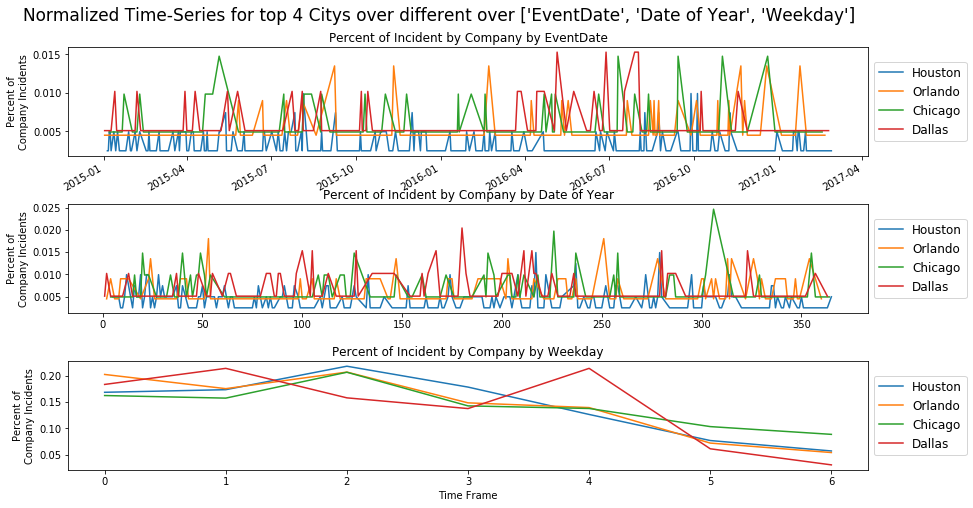

In [17]:
cat_time_slicer(df=df, slicevar = "City",
                n=4, timeframes=["EventDate","Date of Year","Weekday"])

**Interpretation:** <br>
More volatile here. Path worth pursuing.
***
**By State:** <br>

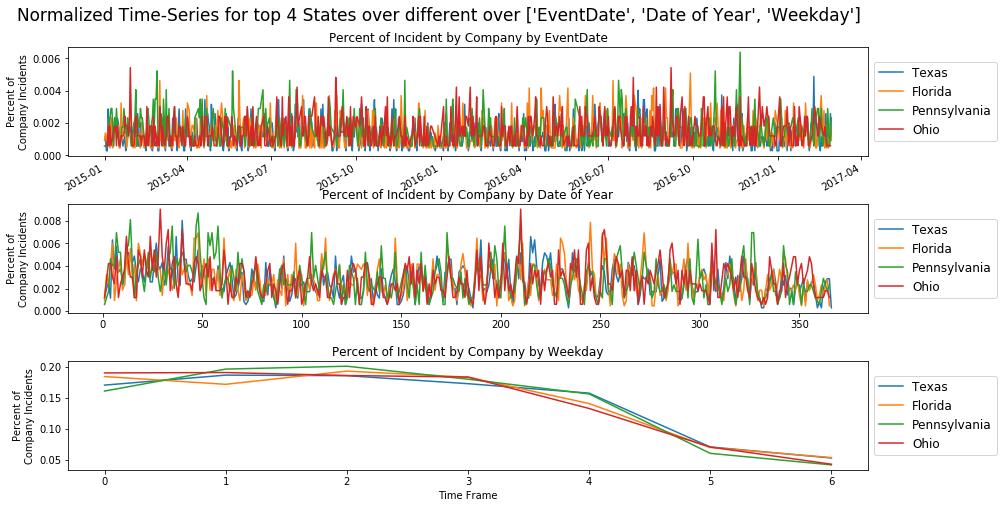

In [18]:
cat_time_slicer(df=df, slicevar = "State",
                n=4, timeframes=["EventDate","Date of Year","Weekday"])

**Interpretation:** <br>
More-or-less same behavior over states.

***
**Boolean Amputated:** <br>

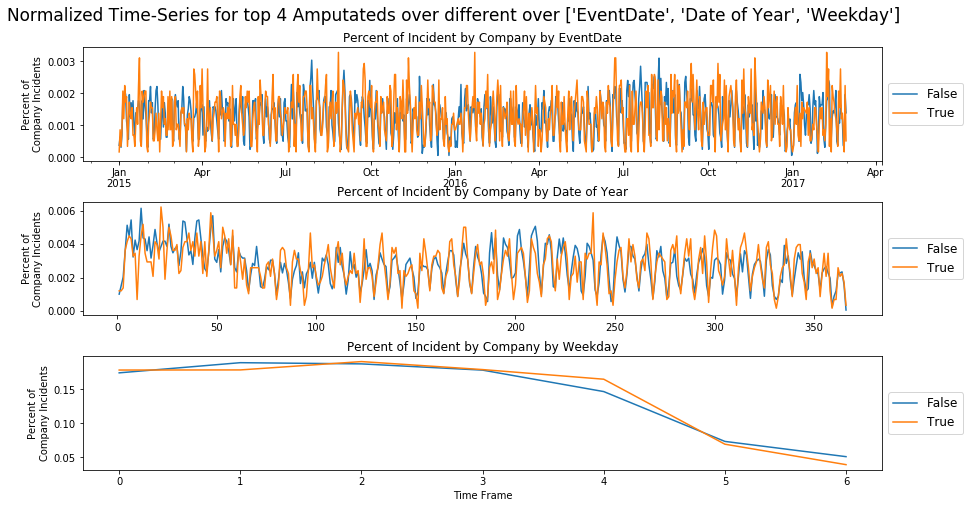

In [19]:
cat_time_slicer(df=df, slicevar = "Amputated",
                n=4, timeframes=["EventDate","Date of Year","Weekday"])

**Interpretation:** <br>
No substantial difference.
***
**By Gender:** <br>

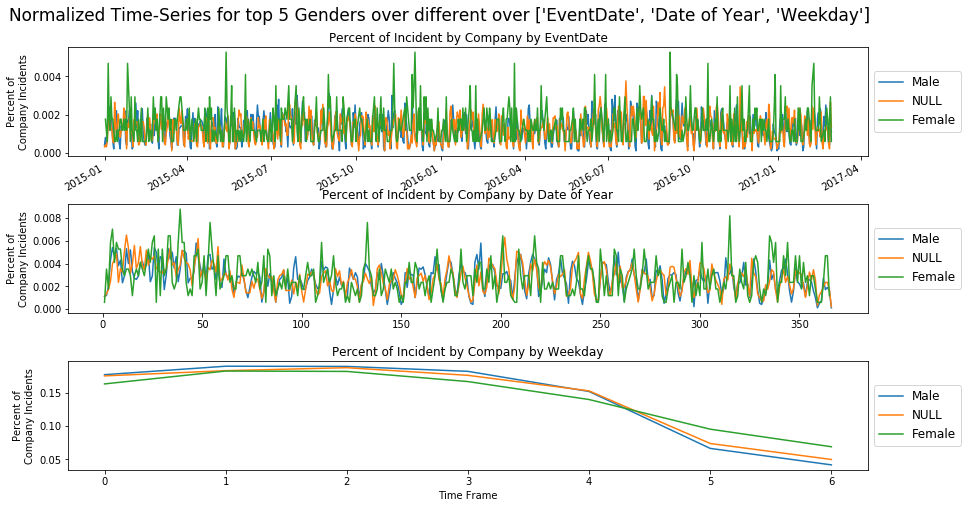

In [24]:
cat_time_slicer(df=df[df["Gender"] != "Both Mentioned"], slicevar = "Gender",
                n=5, timeframes=["EventDate","Date of Year","Weekday"])


***
**Next:** <br>
I want to combine the Time-Series Plotting and the Amputation Rate metric to dive deeper into the most dangerous time to work.

***

## Some Horrible Reports - BEWARE

In [21]:
[print("{}\n".format(x)) for x in 
 df["Final Narrative"].loc[
     (df["Amputated"]==True) & 
     (df["Final Narrative"]
      .str.contains(r"(?i)gun|(?i)burn|(?i)shock"))]
 .sample(10)]

An employee was using a hydraulic pop rivet gun to repair a railcar. The employee's finger was amputated when they pulled the trigger.

An employee received an electrical shock while repairing 7200 KV power lines resulting in hospitalization and the amputation of three fingers on his left hand.

1. On 11/1/15, an employee was changing the reel of paper and caught the left middle finger in a nip point. The finger was amputated to the first knuckle.


2. On 11/11/15, an employee received chemical and thermal burns to the right hand and knee from caustic hydrogen peroxide due to an unclosed valve on the pulp mill equipment. 

Note to user: This record contains two separate events that were reported simultaneously to OSHA by the employer.  These events are captured as one report.

An employee was on a canning line, blowing down station with an air gun, and the right hand drifted into the conveyor subsequently catching the ring finger on the conveyor resulting in injury. At the hospital, pa

[None, None, None, None, None, None, None, None, None, None]

**Interpretation:** <br>
These are terrible accidents. 

## Text Mining

***
Lots of crazy line plots as usual. Super interesting dataset, I'll probably keep coming back to it.

_-Nick_